# Figure 4

This notebook includes the code to reproduce Figure 4a: SAOD distribution of the 1000 stochastic scenarios, and Figure 4b: the GMST anomalies projections under SSP2-4.5.

---------------

Written by May Chim

Last updated: 31 July 2024

---------------

## Import packages and figure adjustment

In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import re
import pandas as pd
import seaborn as sns 
import matplotlib.ticker as ticker
import matplotlib.patches as patches

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

plt.rc('font', size=16) # controls default text sizes          
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

## Read data

In [3]:
# Directory of data files
os.chdir('<path-to-directory-of-data>')

### Read FaIR simulation results
# Future projection with 1000-member stochastic volcanic forcing scenarios
df1 = xr.open_dataset('stochastic_volcanoes.nc')

# Future projection with constant volcanic forcing (CMIP6 ScenarioMIP)
dn = xr.open_dataset('no_future_volcanoes.nc')

#5th, 50th and 95th percentile of SAOD distribution, constant forcing, SSP2-4.5, without internal variability
const_saod = xr.open_dataset('constant_SAOD_scenarios.nc')

In [4]:
# Volcanic forcing input files (EVA_H)

# Output SAOD and ERF mean as dataframe
dir_in = '<path-to-directory-of-data>/Monthly_forcing_files_v2/'
df_saod = []
df_erf = []
df_ens = []

for filename in os.listdir(dir_in):

    if filename.endswith(".csv"):
        
        match = re.search(r'\d+', filename)
        if match:
            file_numbers = match.group()
            file_path = os.path.join(dir_in, filename)
            df = pd.read_csv(file_path)
            saod_mean = df['Global monthly mean SAOD at 550nm'].mean()
            erf_mean = df['Global monthly mean TOA ERF (W/m2)'].mean()
            
            df_ens.append(file_numbers)
            df_saod.append(saod_mean)
            df_erf.append(erf_mean)

data = {'ensemble': df_ens, 'saod_mean': df_saod, 'erf_mean': df_erf}
combined_df = pd.DataFrame(data)

# 5th, median, 95th percentile values of SAOD distribution
saod_median = combined_df['saod_mean'].median()
saod_5_percentile = combined_df['saod_mean'].quantile(0.05)
saod_95_percentile = combined_df['saod_mean'].quantile(0.95)

In [5]:
def calc_uncertainty_bounds(df):
    mean = df.mean(dim='config').rolling(timebounds=10, center=True).mean()
    median = df.median(dim='config').rolling(timebounds=10, center=True).mean()
    percen5 = df.quantile(0.05, dim='config').rolling(timebounds=10, center=True).mean()
    percen95 = df.quantile(0.95, dim='config').rolling(timebounds=10, center=True).mean()

    return median, percen5, percen95

In [6]:
# 5th-95th bound for fair results df1 (with volcanoes and without internal varaibility)
future_ssp245_df1 = df1.temperature[160:,1,:]
median_future_ssp245, percen5_future_ssp245, percen95_future_ssp245 = calc_uncertainty_bounds(future_ssp245_df1)

# 5th-95th bound for volcanic uncertainty
volc_ssp245_range = df1.temperature[160:,1,:] - dn.temperature[160:,1,:]
median_volc_ssp245, percen5_volc_ssp245, percen95_volc_ssp245 = calc_uncertainty_bounds(volc_ssp245_range)

## Figure 4

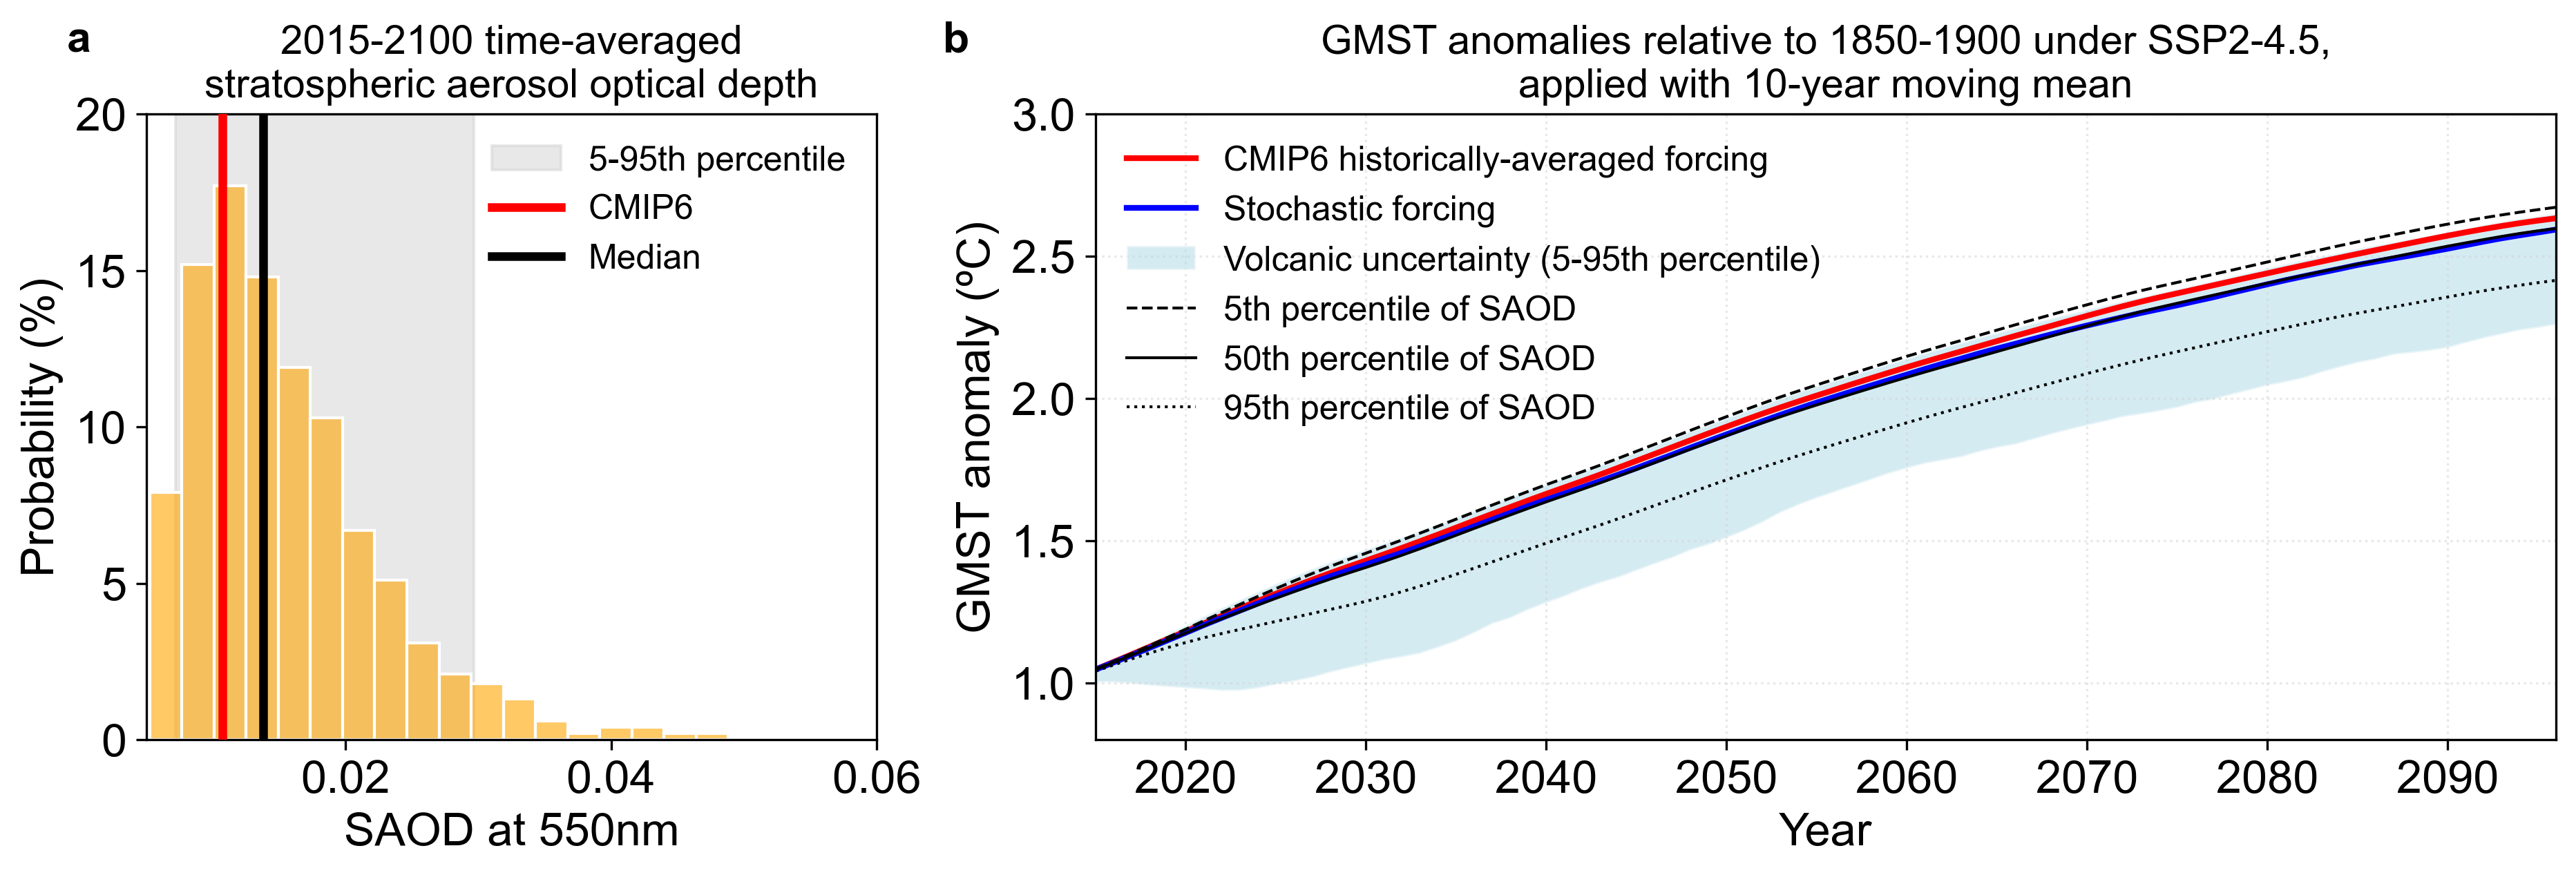

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), dpi=300, gridspec_kw={'width_ratios': [1,2]})

### SAOD distribution plot

# 5-95th percentile SAOD of stochastic scenarios
ax1.axvspan(saod_5_percentile,saod_95_percentile, 
            color = 'lightgrey', alpha = 0.5, label = '5-95th percentile')

# SAOD distribution of stochastic scenarios
sns.histplot(data=combined_df, x="saod_mean", stat="percent", 
             ax=ax1, kde=False, bins = 20,
             color = 'orange', ec = 'white',alpha = 0.6)

# CMIP6 ScenarioMIP SAOD
ax1.axvline(0.0107, color = 'red', lw = 3, label = 'CMIP6', zorder = 11)

# Median SAOD of stochastic scenarios
ax1.axvline(saod_median, color = 'k', lw = 3, label = 'Median', zorder = 10)

# Figure adjustment
ax1.legend(frameon=False, ncol = 1, fontsize = 12)
ax1.set_xlabel('SAOD at 550nm')
ax1.set_title('2015-2100 time-averaged\nstratospheric aerosol optical depth', fontsize = 14)
ax1.set_ylabel('Probability (%)')
ax1.set_xlim(0.005,0.06)
ax1.set_ylim(0,20)

# Figure labels
ax1.text(-0.001,22,'a', fontsize=15, fontweight='bold')
ax1.text(0.065,22,'b', fontsize=15, fontweight='bold')

#################

### GMST projection plot

# Slice data from 2015
df_const_data = const_saod.temperature[165:,]

ax2.grid(axis = 'both', color = 'lightgrey', alpha = 0.5, ls = 'dotted')

time = np.arange(2015,2102,1)

# GMST projection for CMIP6 historically-averaged forcing
ax2.plot(time, const_saod.temperature[160:,:,0].median(dim='config').rolling(timebounds=10, center=True).mean()[5:], 
         lw = 2, color = 'red', label = 'CMIP6 historically-averaged forcing')

# GMST projection for stochastic forcing
ax2.plot(time, median_future_ssp245[5:], lw = 2, color = 'blue', label = 'Stochastic forcing')

# GMST projection for 5-95th volcanic uncertainty
ax2.fill_between(time, median_future_ssp245[5:]+percen5_volc_ssp245[5:], median_future_ssp245[5:]+percen95_volc_ssp245[5:], 
                 color = 'lightblue', alpha = 0.5, ec = 'white', label = 'Volcanic uncertainty (5-95th percentile)')

# GMST projection for 5th percentile of SAOD distribution
ax2.plot(time, const_saod.temperature[160:,:,1].median(dim='config').rolling(timebounds=10, center=True).mean()[5:], 
         lw = 1, color = 'k', label = '5th percentile of SAOD', ls = 'dashed')

# GMST projection for 50th percentile of SAOD distribution
ax2.plot(time, const_saod.temperature[160:,:,2].median(dim='config').rolling(timebounds=10, center=True).mean()[5:], 
         lw = 1, color = 'k', label = '50th percentile of SAOD')

# GMST projection for 95th percentile of SAOD distribution
ax2.plot(time, const_saod.temperature[160:,:,3].median(dim='config').rolling(timebounds=10, center=True).mean()[5:], 
         lw = 1, color = 'k', label = '95th percentile of SAOD', ls = 'dotted')

# Figure adjustments
ax2.legend(loc = 'upper left', frameon=False, ncol = 1, fontsize = 12)
ax2.set_xlim(2015,2096)
ax2.set_ylim(0.8,3)
ax2.set_xlabel('Year')
ax2.set_ylabel('GMST anomaly (ºC)')
ax2.set_title('GMST anomalies relative to 1850-1900 under SSP2-4.5,\napplied with 10-year moving mean', fontsize = 14)

plt.savefig('Figure4.pdf', format = 'pdf')